In [38]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,

)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.utils import first
import matplotlib.pyplot as plt


In [39]:
def prepare(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128, 128, 64], cache=True):
    """
    Preprocess medical imaging data using MONAI transforms and dataloaders.

    Parameters:
    - `in_dir`: Directory containing the dataset.
    - `pixdim`: Desired voxel spacing after resampling (default is (1.5, 1.5, 1.0)).
    - `a_min`, `a_max`: Intensity clipping range for normalization.
    - `spatial_size`: Target spatial size for resizing (default is [128, 128, 64]).
    - `cache`: Whether to cache the dataset in memory (default is True).

    Returns:
    - Tuple of (train_loader, test_loader).
    """

    # Set deterministic behavior for reproducibility
    set_determinism(seed=0)

    # Paths for train and test data
    path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

    # Ensure volumes and segmentations exist
    if not path_train_volumes or not path_train_segmentation:
        raise FileNotFoundError("No training volumes or segmentations found in the specified directory.")
    if not path_test_volumes or not path_test_segmentation:
        raise FileNotFoundError("No testing volumes or segmentations found in the specified directory.")

    # Prepare lists of file dictionaries for training and testing
    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                   zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                  zip(path_test_volumes, path_test_segmentation)]

    # Define training transforms
    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),
        ]
    )

    # Define testing transforms
    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),
        ]
    )

    # Initialize datasets and loaders (cached or non-cached)
    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=4)
    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        test_ds = Dataset(data=test_files, transform=test_transforms)

    train_loader = DataLoader(train_ds, batch_size=1, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

    return train_loader, test_loader


In [40]:
def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    Visualize one patient from your dataset to verify its quality.

    Parameters:
    - `data`: Tuple containing training and testing datasets. Call `prepare` first to pass the data.
    - `SLICE_NUMBER`: The slice number to display (default is 1).
    - `train`: Set to True to display a patient from the training data (default is True).
    - `test`: Set to True to display a patient from the testing data (default is False).
    """

    # Unpack the training and testing datasets
    try:
        check_patient_train, check_patient_test = data
    except ValueError:
        raise ValueError("`data` must be a tuple with (train_data, test_data).")

    # Extract first patient from train and test datasets
    view_train_patient = first(check_patient_train) if check_patient_train else None
    view_test_patient = first(check_patient_test) if check_patient_test else None

    if train and view_train_patient:
        if "vol" not in view_train_patient or "seg" not in view_train_patient:
            raise KeyError("Training data must contain 'vol' and 'seg' keys.")

        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()

    if test and view_test_patient:
        if "vol" not in view_test_patient or "seg" not in view_test_patient:
            raise KeyError("Testing data must contain 'vol' and 'seg' keys.")

        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()

    if not train and not test:
        raise ValueError("At least one of `train` or `test` must be True.")


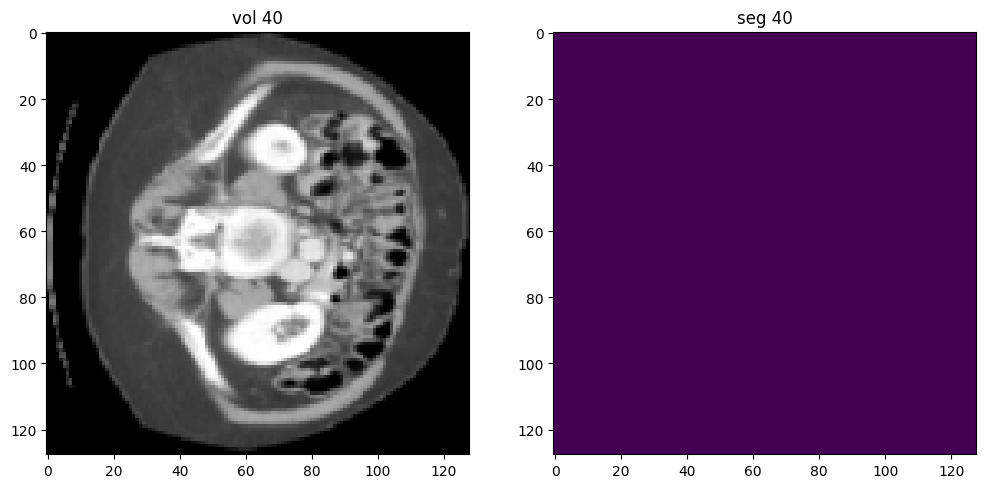

In [42]:
in_dir = r'D:\Liver_Project\Dataset\Data_Train_Test' 
patient = prepare(in_dir) 
show_patient(patient,40)